## **Load the Dataset**

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import re

# Dataset obtained from https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data/download

##### Ratings dataset.
dir = ['combined_data_1.txt','combined_data_2.txt']#,'combined_data_3.txt','combined_data_4.txt']
# Skip the date
df = pd.concat((pd.read_csv(part, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1]) for part in dir),ignore_index=True)

##### Movie title dataset.
# Read the csv file with movie id and names along with year
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
# set index as movie id
df_title.set_index('Movie_Id', inplace = True)

FileNotFoundError: ignored

In [ ]:
df_title.head()

In [ ]:
df.head()

## **Analyze the Datasets**


### Plot graph showing total number of movies, customers, and ranking.

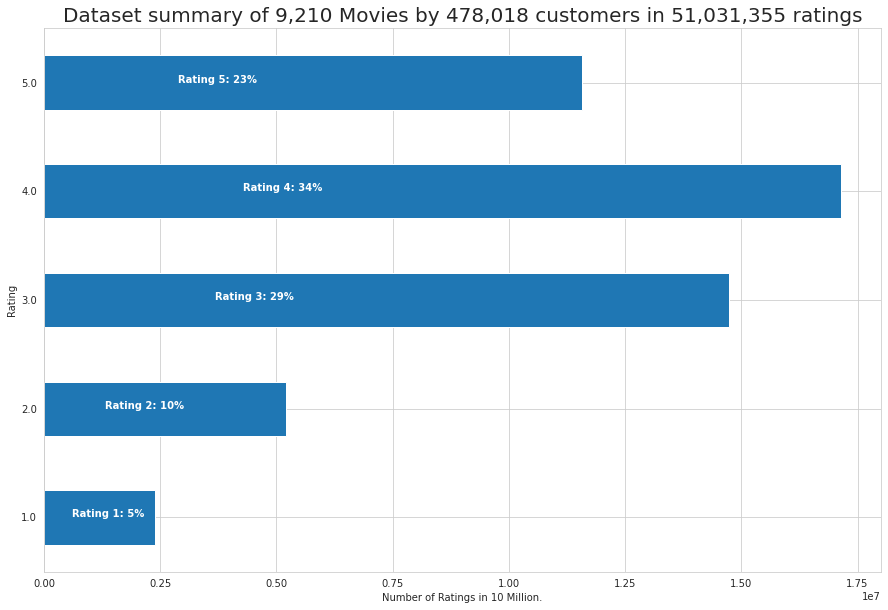

In [ ]:
# Set sns theme.
sns.set_style("whitegrid")

# Find the count of each rating by using group by and aggregating with count.
group_by_ratings = df.groupby('Rating')['Rating'].agg(['count'])

# Since the dataset is not in standard format, we have to extract the movie and customer IDs separately.

# Movies have 'Null' rating in the dataset. So sum them.
movie_counter = df.isnull().sum()[1]

# Customers have ratings provided, but can rate multiple movies.
# So we need to find unique IDs.
customer_counter = df['Cust_Id'].nunique() - movie_counter

# Number of ratings can be obtained by removing the movie/null ratings rows.
ratings_counter = df['Cust_Id'].count() - movie_counter

# We can now plot the data to see how does the number of ratings span.
# We create a bar graph.
graph = group_by_ratings.plot(kind = 'barh', legend = False, figsize = (15,10))

# Chart description
plt.title('Dataset summary of {:,} Movies by {:,} customers in {:,} ratings'.format(
    movie_counter, customer_counter, ratings_counter), fontsize=20)
plt.xlabel('Number of Ratings in 10 Million.')

# Print how much of that rating do we have in our dataset.
for i in range(1,6):
  graph.text(group_by_ratings.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(
      i, group_by_ratings.iloc[i-1][0]*100 /group_by_ratings.sum()[0]), color = 'white', weight = 'bold')

## **Prepare the Dataset**

### Create a separate column for movie ids.

In [ ]:
# Now let's try to clean the dataset for analysis.
# We know that the movie ids are also mixed with the customer ids.
# However, they have no ratings in the ratings column.
# So we can extract the movie titles by finding the null ratings.
movies_only_df = pd.DataFrame(pd.isnull(df.Rating)) # Creates a boolean list for null ratings.
movies_only_df = movies_only_df[movies_only_df['Rating'] == True] # Use that list to get only the movie titles.
movies_only_df = movies_only_df.reset_index()

# Init parameters for running our loop to create a title column.
movie_title_column = []
movie_id = 1

# We run a loop to calculate the distance between one null index and the next.
# Might take over 10 mins to execute due to data size.
for i,j in zip(movies_only_df['index'][1:],movies_only_df['index'][:-1]):
    # We create a list of the movie ids to the length of this distance.
    temp = np.full((1,i-j-1), movie_id)
    # We then append this part to our column list.
    movie_title_column = np.append(movie_title_column, temp)
    # Increase the counter for the next movie.
    movie_id += 1

# The last null value would have to be accounted for separately since we cannot calculate the distance.
# Here, we use the length to subtract from.
last_record = np.full((1,len(df) - movies_only_df.iloc[-1, 0] - 1),movie_id)
# And we can append it to the column list we created.
movie_title_column = np.append(movie_title_column, last_record)

### Exclude rows that have null values in “Rating” column​.

In [ ]:
# Finally we can remove the garbage rows having null values.
df = df[pd.notnull(df['Rating'])]

# Append the column and correct the data type.
df['Movie_Id'] = movie_title_column.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

In [ ]:
# Checking the database at 50mil intervals.
print(df.iloc[::5000000, :])

          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825
25004661  1899206     3.0      4661
30005496   154804     4.0      5496
35006274  2078749     5.0      6274
40007057   450763     5.0      7057
45007991   102092     3.0      7991
50009023   220298     5.0      9023


### Create a dataframe with count and mean of rating for each movie id​.

In [ ]:
del movie_title_column

NameError: ignored

In [ ]:
# Create a list with count and mean to use it for groupby
f = ['count','mean']
# Group movie ids by their count and mean of ratings
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)

In [ ]:
# Convert the index (movie ids) to integer type
df_movie_summary.index = df_movie_summary.index.map(int)
# print index of df_movie_summary
df_movie_summary

### Reduce Size of Dataset​ using movie Ids.

#### Calculate benchmark values for movie ids based on ranking​.

In [ ]:
# Get movie benchmark with value of quantile at 0.7
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)

In [ ]:
# Print out the lowest rating
print('Movie with minimum number of review to filter: {}'.format(movie_benchmark))

Movie with minimum number of review to filter: 1932.0


#### Remove rows that have values less than benchmark​.

In [ ]:
# Only get index of those movies that have count less than benchmark
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
# Print a sample.
drop_movie_list[:10]

Int64Index([1, 2, 4, 5, 6, 7, 9, 10, 11, 12], dtype='int64', name='Movie_Id')

#### Create a dataframe with count and mean of rating for each customer id​.

In [ ]:
# Group customer ids by their count and mean of ratings
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)

### Reduce Size of Dataset​ using customer ids.

#### Calculate benchmark values for customer ids based on ranking​.

In [ ]:
# Convert index (customer Ids ) to int
df_cust_summary.index = df_cust_summary.index.map(int)
# Get customer benchmark with value of quantile at 0.7
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)

# Print out the lowest rating
print('Customer with minimum number of review to filter: {}'.format(cust_benchmark))

Customer with minimum number of review to filter: 108.0


#### Remove rows that have values less than benchmark​.

In [ ]:
# Only get index of those customers that have count below benchmark
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
# Print a sample.
drop_cust_list[:10]

Int64Index([8, 25, 33, 42, 59, 83, 87, 94, 126, 130], dtype='int64', name='Cust_Id')

In [ ]:
# Dataframe shape before filtering.
print('Original Shape: {}'.format(df.shape))

Original Shape: (51031355, 3)


In [ ]:
# Exclude rows from original dataframe for movie ids  that have values are below benchmark
df = df[~df['Movie_Id'].isin(drop_movie_list)]

In [ ]:
# Exclude rows from original dataframe for customer ids that have values are below benchmark
df = df[~df['Cust_Id'].isin(drop_cust_list)]

In [ ]:
# Dataframe shape after filtering.
print('After Trim Shape: {}'.format(df.shape))

After Trim Shape: (36695974, 3)


In [ ]:
# Display the dataframe with a skip value of 5mil.
print('-Data Examples-')
print(df.iloc[::5000000, :])

-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6967414   1772050     5.0      1401
13917453   439970     4.0      2662
20846898  1179317     5.0      3925
27821028  2556129     4.0      5137
34868052  1637761     4.0      6247
41920351  1566168     3.0      7399
48773721     6173     3.0      8782


## **Build function for recommendation system​**

### Create pivot with ”Ranking” as values, “Movie_Id” as column and “Cust_id” as rows. ​

In [ ]:
# Create a pivot to see ratings as values, customer id as rows and movie ids as columns
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
# print the pivot
print(df_p)

### Calculate PearsonR correlation coefficient values depending on the input of movie title names.​

In [ ]:
#=======================================================Build function for Recommedation System===============================================================#
#Calculating the correlation of movie title selected to the rest of the movie titles in the dataframe
def recommend(movie_title, min_count):
    # print movie title name that is passed to this function
    print("For movie ({})".format(movie_title))
    # print top 10 movies recommended based on movie title passed
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    # get index (movie id) of movie name from df_title dataframe
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    # select the column having the target movie id and save it in target varible
    target = df_p[i]
    # find correlation with other movie titles using corrwith() and using PearsonR technique
    similar_to_target = df_p.corrwith(target,method='pearson')
    # Convert similar_to_target to a Dataframe with column name as "PearsonR"
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    # Drop columns that have values as NA from newly created Dataframe (corr_target)
    corr_target.dropna(inplace = True)
    # Sort values in descending order in Dataframe based on "PearsonR" columns
    corr_target = corr_target.sort_values('PearsonR', ascending = False)

    # Convert index to int
    corr_target.index = corr_target.index.map(int)

    # To corr_target Dataframe join other columns from Dataframe based on Movie_ids
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]

    # Print first 10 rows having values greater than min_count provided
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))



## Demonstration

In [ ]:
# 1st Recommendation
# Call recommend function with movie title name and least no. of reviews needed.
recommend("I Love Lucy: Season 2", 0)

In [ ]:
# 2nd Recommendation
# Call recommend function with movie title name and least no. of reviews needed.
recommend("Regular Guys", 0)

## PearsonR manual calculation

In [ ]:
# Manually calculating Pearson's coefficient using formula and verifying the results using corrwith() function
# Get movie ids for Hercules and Paheli movies.
Hercules_movie_id=int(df_title.index[df_title['Name'] == "Hercules"][0])
Paheli_movie_id=int(df_title.index[df_title['Name'] == "Paheli"][0])


In [ ]:
# Find the correlation between these two movies
# Convert series to pandas to use corrwith() function
Hercules = df_p[Hercules_movie_id].to_frame(name="Rating").fillna(0)
Paheli = df_p[Paheli_movie_id].to_frame(name="Rating").fillna(0)
r1= Hercules.corrwith(Paheli,method='pearson')
# Print out the result
print("Pearson's correlation coefficient when we use correlation function : ",round(r1[0],2))


$r =\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$

In [ ]:
# Consider Hercules as X and Paheli as Y
# Here Hercules_mean is X_mean and Paheli_mean is Y_mean
Hercules_mean=Hercules.mean()
Paheli_mean=Paheli.mean()

# Here we calculate (X-X_mean) and (Y-Y_mean)
Hercules_subtract_mean=Hercules-Hercules_mean
Paheli_subtract_mean=Paheli-Paheli_mean

# Calculate the sum of the following operations :
# 1. Compute_1 = ((X-X_mean)* (Y-Y_mean))
# 2. Compute_2 = (X-X_mean)^2
# 3. Compute_3 = (Y-Y_mean)^2
Compute_1 = (Hercules_subtract_mean*Paheli_subtract_mean).sum()
Compute_2 = (Hercules_subtract_mean*Hercules_subtract_mean).sum()
Compute_3 = (Paheli_subtract_mean*Paheli_subtract_mean).sum()

r2 = Compute_1/math.sqrt(Compute_2*Compute_3)
print("Pearson's correlation coefficient when we calculate it using formula : ",round(r2[0],2))
print("As expected, both coefficients values are equal (r1=r2)")

In [ ]:
Compute_1

In [ ]:
math.sqrt(Compute_2*Compute_3)

In [ ]:
Paheli.mean()